## In class Exercise 4

The purpose of this exercise is to practice topic modeling.
Please use the text corpus you collected in your last in-class-exercise for this exercise.

**Expectations**:
*   Students are expected to complete the exercise during lecture period to meet the active participation criteria of the course.
*   Use the provided .*ipynb* document to write your code & respond to the questions. Avoid generating a new file.
*   Write complete answers and run all the cells before submission.
*   Make sure the submission is "clean"; *i.e.*, no unnecessary code cells.
*   Once finished, allow shared rights from top right corner (*see Canvas for details*).

**Total points**: 40

**Deadline**: This in-class exercise is due tonight November 1st, 2023 at 11:59 PM.
**Late submissions cannot be considered.**

## (1) (10 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics.

You may refer the code here:
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [47]:
# Run in python console
import nltk; nltk.download('stopwords')



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [48]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [49]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [102]:
df= pd.read_csv("Reviews.csv")
# Select specific rows (e.g., rows 10 to 20)
selected_rows = df.iloc[1:1000]

print(df.head())

   Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   
3   4  B000UA0QIQ  A395BORC6FGVXV                             Karl   
4   5  B006K2ZZ7K  A1UQRSCLF8GW1T    Michael D. Bigham "M. Wassir"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      5  1303862400   
1                     0                       0      1  1346976000   
2                     1                       1      4  1219017600   
3                     3                       3      2  1307923200   
4                     0                       0      5  1350777600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1 

In [104]:
# Convert to list
data = df.Text.values.tolist()
# Ensure that data is a list of strings
data = [str(sent) for sent in data]

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
# Continue with your data preprocessing steps


# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['I have bought several of the Vitality canned dog food products and have '
 'found them all to be of good quality. The product looks more like a stew '
 'than a processed meat and it smells better. My Labrador is finicky and she '
 'appreciates this product better than most.']


In [105]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['have', 'bought', 'several', 'of', 'the', 'vitality', 'canned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', 'the', 'product', 'looks', 'more', 'like', 'stew', 'than', 'processed', 'meat', 'and', 'it', 'smells', 'better', 'my', 'labrador', 'is', 'finicky', 'and', 'she', 'appreciates', 'this', 'product', 'better', 'than', 'most']]


In [106]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['have', 'bought', 'several', 'of', 'the', 'vitality', 'canned', 'dog', 'food', 'products', 'and', 'have', 'found', 'them', 'all', 'to', 'be', 'of', 'good', 'quality', 'the', 'product', 'looks', 'more', 'like', 'stew', 'than', 'processed', 'meat', 'and', 'it', 'smells', 'better', 'my', 'labrador', 'is', 'finicky', 'and', 'she', 'appreciates', 'this', 'product', 'better', 'than', 'most']


In [107]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# Initialize spaCy with 'en_core_web_sm'
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

In [81]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [82]:
id2word[0]

'dog'

In [83]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('dog', 1), ('food', 1), ('good', 1), ('quality', 1)]]

In [84]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [85]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.000*"adulterated" + 0.000*"reportedly" + 0.000*"ughhh" + 0.000*"satifie" '
  '+ 0.000*"peeeeuuuwwww" + 0.000*"vic" + 0.000*"coconou" + 0.000*"blistering" '
  '+ 0.000*"australia" + 0.000*"ize"'),
 (1,
  '0.774*"good" + 0.202*"product" + 0.011*"stale" + 0.000*"cookie" + '
  '0.000*"excellent" + 0.000*"treat" + 0.000*"oatmeal" + 0.000*"chip" + '
  '0.000*"bad" + 0.000*"snack"'),
 (2,
  '0.000*"adulterated" + 0.000*"reportedly" + 0.000*"ughhh" + 0.000*"satifie" '
  '+ 0.000*"peeeeuuuwwww" + 0.000*"vic" + 0.000*"coconou" + 0.000*"blistering" '
  '+ 0.000*"australia" + 0.000*"ize"'),
 (3,
  '0.945*"great" + 0.025*"expect" + 0.015*"lot" + 0.000*"cookie" + '
  '0.000*"treat" + 0.000*"excellent" + 0.000*"oatmeal" + 0.000*"chip" + '
  '0.000*"snack" + 0.000*"bad"'),
 (4,
  '0.329*"cat" + 0.169*"way" + 0.112*"new" + 0.068*"day" + 0.067*"regular" + '
  '0.046*"diet" + 0.036*"rock" + 0.033*"start" + 0.030*"nutrition" + '
  '0.027*"warn"'),
 (5,
  '0.923*"taste" + 0.033*"home" + 0.006*"de

In [86]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -20.190326373755507

Coherence Score:  0.2532206994263807


In [92]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

In [ ]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

In [ ]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
                     if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

## (2) (10 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics.

You may refer the code here:
https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [132]:
#import modules
import os.path
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
number_of_topics:any






In [133]:
import os

def load_data(path, file_name, max_lines=None):
    """
    Input  : path and file_name
             max_lines: Maximum number of lines to read from the file (None means read all)
    Purpose: Loading text file with an option to limit the number of lines read
    Output : List of paragraphs/documents and
             title (initial 100 words considered as the title of the document)
    """
    documents_list = []
    titles = []
    with open(os.path.join(path, file_name), "r") as fin:
        for i, line in enumerate(fin):
            if max_lines is not None and i >= max_lines:
                break  # Stop reading after reaching the specified maximum lines
            text = line.strip()
            documents_list.append(text)
            titles.append(text[0:min(len(text), 100)])

    print("Total Number of Documents:", len(documents_list))
    print(titles)
    return documents_list, titles

In [134]:
document_list,titles=load_data("","Reviews.csv", max_lines=1000)

Total Number of Documents: 1000
['Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text', '1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several ', '2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Ju', '3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it', '4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret i', '5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great ta', '6,B006K2ZZ7K,ADT0SRK1MGOEU,Twoapennything,0,0,4,1342051200,Nice Taffy,"I got a wild hair for taffy a', '7,B006K2ZZ7K,A1SP2KVKFXXRU1,David C. Sullivan,0,0,5,1340150400,Great!  Just as good as the expensive', '8,B006K2ZZ7K,A3JRGQVEQN31IQ,Pamela G. Williams,0,0,5,1336003200,"Wonderful, tasty taffy",This taffy ', "9,B000E7L2R4,A1MZYO9TZK0BBI,R. 

In [135]:
# Download the stopwords resource
import nltk
nltk.download('stopwords')

# Now you can proceed with your text preprocessing
from nltk.corpus import stopwords



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [136]:
def preprocess_data(doc_set):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    # initialize regex tokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    # create English stop words list
    en_stop = set(stopwords.words('english'))
    # Create p_stemmer of class PorterStemmer
    p_stemmer = PorterStemmer()
    # list for tokenized documents in loop
    texts = []
    # loop through document list
    for i in doc_set:
        # clean and tokenize document string
        raw = i.lower()
        tokens = tokenizer.tokenize(raw)
        # remove stop words from tokens
        stopped_tokens = [i for i in tokens if not i in en_stop]
        # stem tokens
        stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
        # add tokens to list
        texts.append(stemmed_tokens)
    return texts

In [137]:
clean_text=preprocess_data(document_list)

In [138]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [142]:
def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various numbers of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # Generate LSA model
        model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary)  # Train model
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values


In [143]:
def plot_graph(doc_clean,start, stop, step):
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean,
                                                            stop, start, step)
    # Show graph
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()



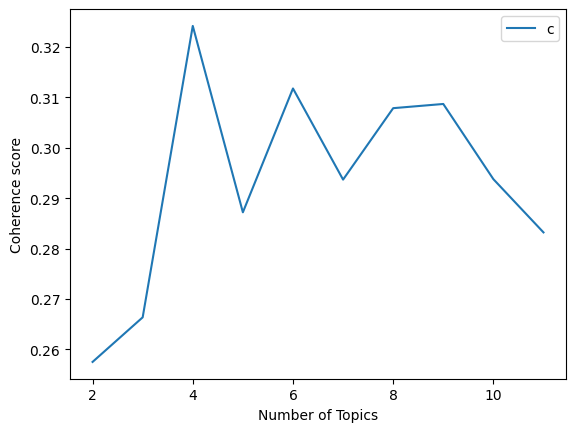

In [144]:
plot_graph(clean_text,2,12,1)

In [126]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    number_of_topics = int
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel


In [121]:
model=create_gensim_lsa_model(clean_text,5,10)

[(0, '0.713*"br" + 0.337*"chip" + 0.140*"0" + 0.136*"flavor" + 0.134*"like" + 0.132*"5" + 0.128*"kettl" + 0.123*"bag" + 0.122*"potato" + 0.121*"tast"'), (1, '-0.608*"chip" + 0.566*"br" + -0.201*"kettl" + -0.200*"0" + -0.172*"flavor" + -0.144*"brand" + -0.119*"bag" + -0.118*"b000g6ryne" + 0.101*"organ" + -0.089*"great"'), (2, '-0.408*"0" + 0.394*"chip" + -0.251*"5" + 0.225*"br" + -0.195*"food" + 0.189*"kettl" + -0.167*"tast" + -0.162*"tea" + 0.161*"potato" + -0.159*"like"'), (3, '-0.643*"tea" + 0.457*"food" + 0.209*"1" + -0.186*"0" + 0.182*"dog" + -0.169*"drink" + 0.159*"cat" + -0.129*"coffe" + -0.124*"tast" + 0.117*"eat"'), (4, '-0.313*"flavor" + -0.307*"0" + 0.270*"tea" + 0.253*"bag" + 0.226*"1" + 0.222*"food" + 0.219*"flavour" + -0.193*"organ" + 0.167*"potato" + 0.150*"eat"')]


## (3) (10 points) Generate K topics by using  lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics.

You may refer the code here:
https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

In [ ]:
# Write your code here

# Install and import libraries
!pip install lda2vec
!pip install --upgrade lda2vec

import numpy as np
import pandas as pd
from lda2vec import preprocess, Corpus
from lda2vec import LDA2Vec
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis

# Load and preprocess your text data
# Load your data into a DataFrame
data = pd.read_csv("Reviews.csv")

# Preprocess the text data as needed (e.g., tokenization, stop-word removal)
documents = data['Text'].values

# Create a document-term matrix (DTM)
tokenized_documents, vocab = preprocess.tokenize(documents)
corpus = Corpus()
corpus.update(tokenized_documents, vocab)

# Calculate coherence scores for different values of K
coherence_scores = []
for k in range(2, 21):  # You can adjust the range as needed
    model = LDA2Vec(n_topics=k, n_doc=corpus.num_docs, n_vocab=len(vocab))
    model.fit(corpus, n_samples=1000, log_fn=None)

    # Calculate coherence score (you can use your preferred coherence measure)
    coherence_score = model.calculate_coherence()
    coherence_scores.append(coherence_score)

# Find the optimal number of topics (K)
optimal_k = np.argmax(coherence_scores) + 2  # Add 2 because we started from K=2

# Train LDA2Vec with the optimal number of topics
model = LDA2Vec(n_topics=optimal_k, n_doc=corpus.num_docs, n_vocab=len(vocab))
model.fit(corpus, n_samples=1000, log_fn=None)

# Visualize and summarize the topics
vis_data = gensimvis.prepare(model, corpus, corpus.id2word)
pyLDAvis.display(vis_data)

# Summarize the topics
topic_words = model.topic_words
for i, words in enumerate(topic_words):
    print(f"Topic {i}: {', '.join(words)}")




## (4) (10 points) Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics.

You may refer the code here:
https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [145]:
# Write your code here
%%capture
!pip install bertopic





In [ ]:
document= pd.read_csv("Reviews.csv")
# Select specific rows (e.g., rows 10 to 20)
selected_rows = df.iloc[1:100]
docs = data['Text'].values

print(docs.head())

In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

In [ ]:
freq = topic_model.get_topic_info(); freq.head(5)

In [ ]:
topic_model.get_topic(0)  # Select the most frequent topic

In [ ]:
topic_model.topics_[:10]

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [ ]:
topic_model.visualize_barchart(top_n_topics=5)

In [ ]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

In [ ]:
topic_model.visualize_term_rank()

In [ ]:
topic_model.update_topics(docs, n_gram_range=(1, 2))

In [ ]:
topic_model.get_topic(0)

In [ ]:
topic_model.reduce_topics(docs, nr_topics=60)

In [ ]:
# Access the newly updated topics with:
print(topic_model.topics_)

In [ ]:
similar_topics, similarity = topic_model.find_topics("vehicle", top_n=5); similar_topics

In [ ]:
topic_model.get_topic(71)

In [ ]:
# Save model
topic_model.save("my_model")

In [ ]:
# Load model
my_model = BERTopic.load("my_model")

In [ ]:
topic_model = BERTopic(embedding_model="xlm-r-bert-base-nli-stsb-mean-tokens")

In [ ]:
from sentence_transformers import SentenceTransformer

sentence_model = SentenceTransformer("distilbert-base-nli-mean-tokens", device="cpu")
topic_model = BERTopic(embedding_model=sentence_model, verbose=True)

## (5) (10 extra points) Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.

Follow the guidelines from the essay to enhance your explanation:

* Writing logic

  Pay attention to how you express your thoughts. For example:

  * Weak Writing Logic: “Artificial Intelligence is risky because it is new technology.”

  * Strong Writing Logic: “Artificial Intelligence presents ethical risks such as data privacy concerns and algorithmic bias, which necessitate cautious implementation and regulation.”

* Topic of sentences

  * Focus and Direction: It provides a focus and sets the direction for the paragraph, ensuring that the reader knows what to expect.
  * Reader Guidance: It serves as a guidepost for the reader, making it easier to follow the flow of ideas and arguments in the document.
  * Support for Thesis: In academic papers, topic sentences help in elaborating or providing evidence for the thesis statement or research question.

* Writing flow

  * Transition: Smooth and logical transitions between sentences, paragraphs, and sections.
  * Rhythm: Variation in sentence length and structure to maintain reader engagement.
  * Sequence: The order of points or arguments contributes to a smooth reading experience.
  For example:
    * Weak Writing Flow: “We studied machine learning algorithms. Ethics are important. Data was collected.”
    * Strong Writing Flow: “We initiated our study by focusing on machine learning algorithms. Recognizing the ethical implications, we carefully curated our data set.”

I have utilized the Amazon fine food reviews data set, which consists of consumer reviews, to model topics using all four models. In order to compare the output produced by the four topic modeling algorithms—LDA, LSA, BERTopic, and LDA2Vec—it is necessary to assess each one's performance using a range of standards, including interpretability, coherence, and dataset relevance. Let's examine each of these approaches in detail and evaluate their advantages and disadvantages.

In order to decide which approach is superior, we must take into account the particular needs of the analysis When interpretability is of the utmost importance, LDA is a wise option. It is popular and yields results that are easily comprehended.
When working with huge datasets and trying to capture latent semantic links, LSA is a good fit.When the dataset has a lot of context and using transformer-based embeddings is desirable, BERTopic is useful.Combining the advantages of LDA and word embeddings, LDA2Vec is appropriate for situations where a subtle interpretation of themes is required.

Based on the results for my dataset LDA is good choice As LDA is excellent in many ways, it's crucial to understand that no topic modeling method is better than the others. The particulars of your data and the objectives of your study will determine which subject modeling technique is best for you. For complicated text data, more sophisticated techniques like BERTopic, lda2vec, and LSA might be helpful. In conclusion, LDA is a great option when a solid foundation and interpretability are priorities, but the ideal approach will depend on the specifics of your project.




In [ ]:
# Write your answer here (no code needed for this question)



